<a href="https://colab.research.google.com/github/alen-ka/githubTest/blob/main/Lab_3_Ex_1_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PLEASE NOTE - THERE ARE TWO NOTEBOOKS IN LAB 3!

# This notebook is for working through some classifier comparison techniques
# it corresponds to Lecture Handouts 3 and 4.
#
# The questions are:
#  -- Section 1: binary (two-class) classification (Lab 3 Ex. 1)  --
#   i) Evaluate & compare the ROC curves for different classifiers.
#  ii) Influence the classifier performance by introducing class weights.
#
#  -- Section 2: multi-class classification (Lab 3 Ex. 2) --
# iii) Evaluate & compare classifiers using the confusion matrix.
#  iv) Classifier selection with practical criteria.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-03/

Mounted at /content/gdrive
/content/gdrive/MyDrive/4c16-labs/code/lab-03


In [ ]:
# Autoload setup (you don't need to edit this cell); instructions to:
#   i) enable autoreloading of modules
%load_ext autoreload
#  ii) import the module 'lab_3' (which will contain your functions) in an autoreloadable way
%aimport lab_3
# iii) indicate that we want autoreloading to happen on every evaluation.
%autoreload 1

In [ ]:
%%javascript
// This cell disables scrollbars on our output, which is handier when we want to do lots of plots.
// Don't edit this cell!
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
##############################################################
#
# Import useful libraries
#
# As well as numpy and matplotlib, this lab makes extensive use of a module
# called 'scikit-learn' (sklearn); this provides a number of machine learning
# tools and ready-built classifiers, as well as some datasets for experimentation.
#
# We are also using the module'pandas' for tabulated display of data.
#
#
##############################################################
import pandas as pd
import numpy as np
import sklearn as skl

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.7

from sklearn import datasets

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
# This is a utility function to show a scatter plot of binary-valued
# data (i.e. 'y' has values 0 and 1), against attributes 'X'; X must
# have at least two columns, and only the first two are used (as the
# x and y axes for the scatter).

def scatterplot_binary_data(X, y):
    x_axis_min, x_axis_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_axis_min, y_axis_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.figure(figsize=plt.figaspect(1.0)).add_subplot(111)
    # Plot the  points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
    ax.set_xlim(x_axis_min, x_axis_max)
    ax.set_ylim(y_axis_min, y_axis_max)

In [ ]:
# This function takes a dictionary of classifiers, and some training and test data,
# and computes ROC data for each.
#
# The dictionary of classifiers should have entries 'name' -> scikit classifier.
#
# This does the fitting and the evaluation on each invocation.
#
# Not all the SciKit-Learn classifiers have a 'decision_function' method; for
# those that don't, this method uses 'predict_proba' (for predicted probablity).
# See the SciKit-Learn documentation for the distinction.

def evaluate_classifiers_ROC(classifiers, X_train, y_train, X_test, y_test):
    results = dict()

    for classifier_name, classifier in classifiers.items():
        this_result = dict()

        classifier.fit(X_train, y_train)
        this_result['y_prediction'] = classifier.predict(X_test)

        if (hasattr(classifier, 'decision_function')):
            this_result['y_score'] = classifier.decision_function(X_test)
        else:
            this_result['y_score'] = classifier.predict_proba(X_test)[:,1]


        # fpr == False positive rate
        # tpr == True positive rate
        # auc == Area under curve
        this_result['fpr'], this_result['tpr'], _ = skl.metrics.roc_curve(y_test, this_result['y_score'])
        this_result['roc_auc'] = skl.metrics.auc(this_result['fpr'], this_result['tpr'])
        results[classifier_name] = this_result
    return results

In [ ]:
# This function draws a set of ROC curves with labels.
#
# The input data, 'results', should be obtained by calling 'evaluate_classifiers_ROC'.
#
# The axis limits of the plot can be overridden, e.g. to zoom in on the upper-left corner.

def plot_ROCs(results, xlim=[0.0, 1.0], ylim=[0.0, 1.05]):
    ax = plt.figure(figsize=(8, 8)).add_subplot(111)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Comparison')

    for classifier_name, result in results.items():
        plt.plot(result['fpr'], result['tpr'],
                 lw=2, label=classifier_name + ': (auc = %0.4f)' % result['roc_auc'])

    plt.legend(loc="lower right");

In [ ]:
# This function displays a table of classifier metrics.
#
# The input data, 'results', should be obtained by calling 'evaluate_classifiers_ROC'.


def show_classifier_metrics(results, true_labels):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import f1_score
    from IPython.display import display

    metrics = {}

    for name, result in results.items():
        m = {}  # This will store the metrics for the present classifier.

        # 'FPR at total recall' is a measure of the ROC curve.
        # It means: "Set the decision threshold to the lowest value at which the classifier
        # correctly identifies all the true positives in the test set.  At this threshold,
        # what fraction of the negative examples in the test set were identified as positives?".
        # Lower values are better.
        total_recall_index = np.argmax(result['tpr'] >= 0.999)
        m['fpr_at_total_recall'] = result['fpr'][total_recall_index]

        # These metrics are not measures against the ROC curve, but rather measures
        # of classification performance at a particular operating point.  For most
        # classifiers this is 'classify as class having the highest score'.
        predicted_labels = result['y_prediction']
        m['precision'] = precision_score(true_labels, predicted_labels)
        m['recall'] = recall_score(true_labels, predicted_labels)
        m['f1'] = f1_score(true_labels, predicted_labels)
        m['accuracy'] = accuracy_score(true_labels, predicted_labels)

        metrics[name] = m

    # We take the transpose so that each classifier is a column, rather than a row,
    # and so the table grows vertically (convenient) rather than horizontally (inconvenient)
    # as we add classifiers.
    df = pd.DataFrame(metrics).transpose()
    display(df)

In [ ]:
# Exercise 1 Part 1 -- synthetic data.
#
# Set up some off-the-shelf classifiers from the sklearn package

classifiers = {
    'Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Logistic':          LogisticRegression(),
    'Linear SVM' :       SVC(kernel="linear"),
    'RBF SVM'    :       SVC(),
    'Decision Tree' :    DecisionTreeClassifier(max_depth=5)
}

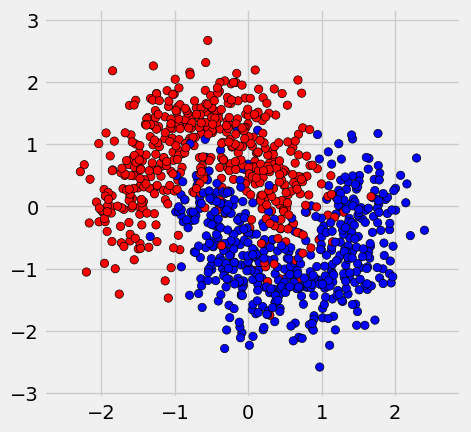

In [ ]:
# First we generate and inspect some synthetic data, using one of the scikit-learn convenience
# functions to create a fairly tricky source distribution.
#
# Experiment with different amounts of noise to see how it affects the data.

X, y = skl.datasets.make_moons(n_samples=1000, noise=0.3, random_state=0)
X = StandardScaler().fit_transform(X)
scatterplot_binary_data(X, y)

,fpr_at_total_recall,precision,recall,f1,accuracy
Nearest Neighbors,1.000000,0.887597,0.930894,0.908730,0.908
Logistic,0.685039,0.818898,0.845528,0.832000,0.832
Linear SVM,0.681102,0.803846,0.849593,0.826087,0.824
RBF SVM,0.909449,0.858209,0.934959,0.894942,0.892
Decision Tree,1.000000,0.900415,0.882114,0.891170,0.894


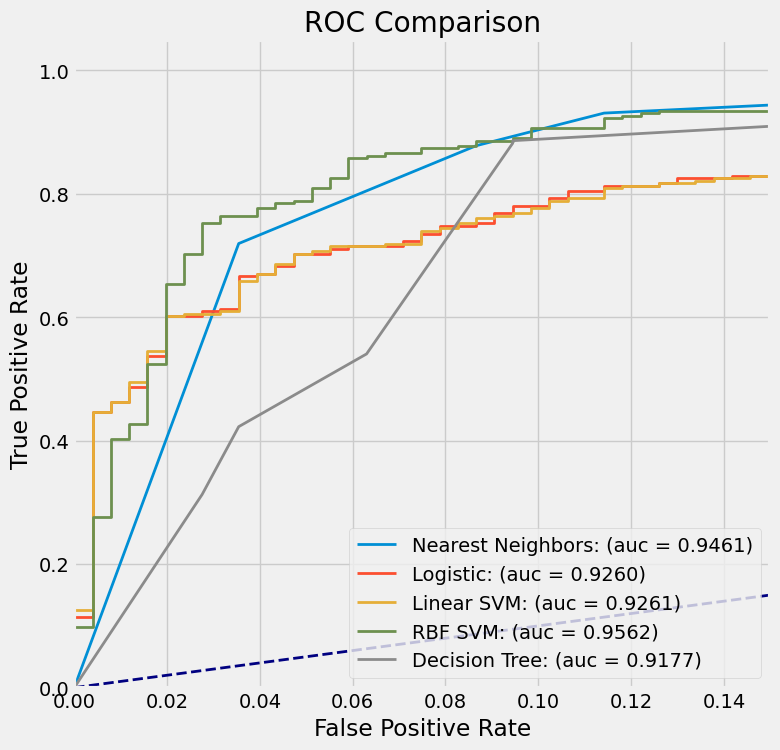

In [ ]:
# Split the data into training and test sets (50/50), using another sklearn convenience function.
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=.5, random_state=0)

# Run this data through our classifiers, evaluating the ROC for each.
results_synthetic = evaluate_classifiers_ROC(classifiers, X_train, y_train, X_test, y_test)

# Show the result metrics and the ROC curves.
xlim = [0.0, 0.15]
ylim = [0.0, 1.05]
plot_ROCs(results_synthetic, xlim, ylim)
show_classifier_metrics(results_synthetic, y_test)

In [ ]:
#
# Quiz: Which classifier has the highest TPR for an FPR of 15%? (hint: change the axis limits!)
#
# Provide your answer in the function 'question_1' in the lab module ('lab_3.py').

In [ ]:
#
# This is Part 2: Real Data
#

In [ ]:
# Load up one of the standard datasets provided by the SciKit-Learn package.
data = skl.datasets.load_breast_cancer()

# In this data set, a label of '0' signifies malignant growth, and '1' signifies benign.
print("Target names: " + str(data.target_names))
print("\nDataset description:\n")
print(data.DESCR)

X_real = data.data
# Scale each feature to be 0-mean with variance 1.  Strictly speaking this should
# be done by fitting the transform to the training set and using that fit to
# normalize both the training and test data (rather than incroporating the test
# data into the computation of the fit).
X_real = StandardScaler().fit_transform(X_real)

# In this dataset, 'malignant' is coded with 0, but for ROC analysis it is
# a little more convenient to think of detection, i.e. 'present' vs 'not present',
# and so we will adjust the data so that 1 codes for 'malignant' (which we are
# trying to detect).
y_real = 1 - data.target

Target names: ['malignant' 'benign']

Dataset description:

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, 

,fpr_at_total_recall,precision,recall,f1,accuracy
Nearest Neighbors,1.000000,0.957447,0.891089,0.923077,0.947368
Logistic,0.375000,0.970000,0.960396,0.965174,0.975439
Linear SVM,0.206522,0.941176,0.950495,0.945813,0.961404
RBF SVM,0.217391,0.969697,0.950495,0.960000,0.971930
Decision Tree,1.000000,0.923913,0.841584,0.880829,0.919298


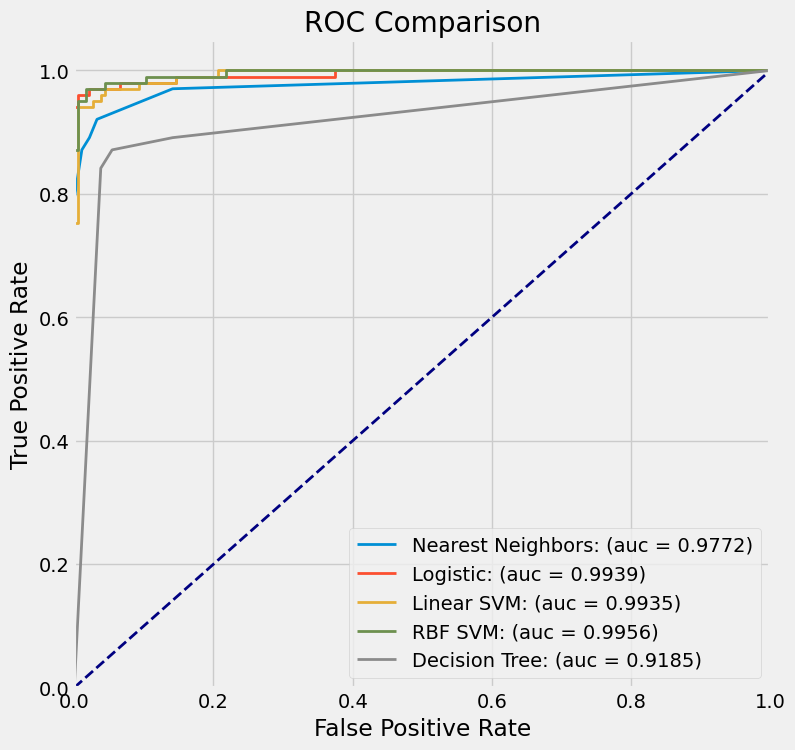

In [ ]:
# Again we split the data into training and test sets, 50/50.
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X_real, y_real, test_size=.5, random_state=0)

# We push this data through the functions defined above to compute metrics and plot ROCs.
results_real_data = evaluate_classifiers_ROC(classifiers, X_train, y_train, X_test, y_test)
plot_ROCs(results_real_data)
show_classifier_metrics(results_real_data, y_test)

In [ ]:
# There is a problem with the approach we've taken above: it considers the two
# classes ('benign' & 'malignant') equally important (in the sense that the
# base rate for classification corresponds to the relative prevalance of
# each class in the training set).
#
# We want to be sure to detect malignancy, and so errors in classification of
# (true) malignant samples should count for more than errors in classification
# of benign samples, even if malignancy is less common than benignity.
#
# In the next cell we use class weights to influence our classifiers in this way.
# We will only evaluate the Linear SVM classifier, as it got the best performance
# in the 'fpr at 100% recall' rate.

In [ ]:
# Set up another set of classifiers, this time with class weights.

classifiers_w = {
    # The default is no class weights, which is the same as setting a weight of 1 on every class.
    'SVM-no_weight': SVC(kernel="linear", class_weight=None),
    # 'balanced' is a special option which sets weights to offset any disparity in prevalence in the training data.
    'SVM-balanced':  SVC(kernel="linear", class_weight='balanced'),
}

# We will add in a set of classifiers with numerically set weights for class 1---malignant.
# These weights are greater than 1, so they increase the importance of this class.
weights = [1 + 0.05*x for x in range(1,11)]

for w in weights:
    classifier_name = ('SVM-weight-%0.2f' % w)
    classifiers_w[classifier_name] = SVC(kernel="linear", class_weight={1: w})

from matplotlib import pyplot as plt
_df_22['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_23['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

,fpr_at_total_recall,precision,recall,f1,accuracy
SVM-no_weight,0.206522,0.941176,0.950495,0.945813,0.961404
SVM-balanced,0.146739,0.923810,0.960396,0.941748,0.957895
SVM-weight-1.05,0.195652,0.932039,0.950495,0.941176,0.957895
SVM-weight-1.10,0.184783,0.932039,0.950495,0.941176,0.957895
SVM-weight-1.15,0.168478,0.923077,0.950495,0.936585,0.954386
SVM-weight-1.20,0.163043,0.923077,0.950495,0.936585,0.954386
SVM-weight-1.25,0.163043,0.932039,0.950495,0.941176,0.957895
SVM-weight-1.30,0.163043,0.941176,0.950495,0.945813,0.961404
SVM-weight-1.35,0.146739,0.932039,0.950495,0.941176,0.957895
SVM-weight-1.40,0.152174,0.914286,0.950495,0.932039,0.950877


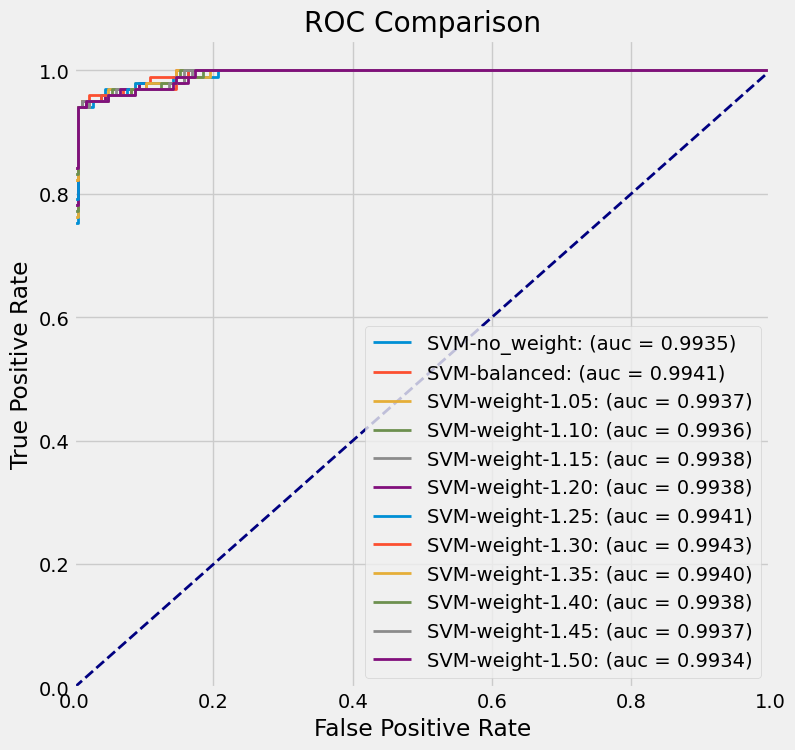

In [ ]:
# Now we evaluate this new set of classifiers, which use the weights, and examine the performance.
results_real_data = evaluate_classifiers_ROC(classifiers_w, X_train, y_train, X_test, y_test)
xlim = [0.0, 1.0]
ylim = [0.0, 1.05]
plot_ROCs(results_real_data, xlim, ylim)
show_classifier_metrics(results_real_data, y_test)

In [ ]:
#
# Quiz: Identify the numerical value of the weight which minimizes the fpr for total recall
# FP rate = FP/(FP+TN)
# Look at the metrics
# Provide your answer in the function 'question_2' in the lab module ('lab_3.py').